In [11]:
import pandas as pd 
import numpy as np
import gurobipy as gb
import os
import matplotlib.pyplot as plt


In [12]:
data_folder_path = os.path.join(os.path.dirname(os.getcwd()), 'raw_data')
data_files_path = os.listdir(data_folder_path)

In [13]:
data_da = pd.DataFrame()
data_id = pd.DataFrame()
corrupted_data = []

for file_path in data_files_path:

    data_file_path = os.path.join(data_folder_path,file_path)

    try:
        single_day_data = pd.read_csv(data_file_path, sep=';', skiprows=1, header=None, encoding = 'latin-1')
        single_day_data = single_day_data.iloc[:-1,:-1] # filtering out last row and columns which are blank

        if file_path.split('_')[0] == 'marginalpdbc':

            single_day_data.columns = ['Year','Month','Day','Hour','DA PT','DA ES'] # changing column names
            cols = list(range(4)) + [5] #selecting only dates and Spain data columns
            

            if len(single_day_data) == 24:
                data_da = pd.concat([data_da,single_day_data.iloc[:,cols]])
            elif len(single_day_data) > 24:
                data_da = pd.concat([data_da,single_day_data.iloc[:-1,cols]])
            elif len(single_day_data) < 24:
                hour_to_add = single_day_data.iloc[-1].copy()
                hour_to_add.iloc[4:] = np.nan
                hour_to_add.iloc[3] = 24
                single_day_data_corrected = pd.concat([single_day_data,hour_to_add.to_frame().T])
                data_da = pd.concat([data_da,single_day_data_corrected.iloc[:,cols]])

        else:
            single_day_data.columns = ['Year','Month','Day','Hour','MaxES','MaxPT','MaxMO','MinES','MinPT','MinMO','AvgES','AvgPT','AvgMO']
            single_day_data = single_day_data.iloc[1:] # removing first row which are old headers not values
            cols = list(range(5)) + [7, 10] #selecting only dates and Spain data columns

            if len(single_day_data) == 24:
                data_id = pd.concat([data_id,single_day_data.iloc[:,cols]])
            elif len(single_day_data) > 24:
                data_id = pd.concat([data_id,single_day_data.iloc[:-1,cols]])
            elif len(single_day_data) < 24:
                # copying last hour data to missing hour 24
                hour_to_add = single_day_data.iloc[-1].copy()
                hour_to_add.iloc[4:] = np.nan
                hour_to_add.iloc[3] = 24
                single_day_data_corrected = pd.concat([single_day_data,hour_to_add.to_frame().T])
                data_id = pd.concat([data_id,single_day_data_corrected.iloc[:,cols]])

        if len(single_day_data) != 24:
            print(f'Hours recorded in {file_path}:', len(single_day_data))
            corrupted_data.append(single_day_data)



    except Exception as e:
        print(e)
        print(f'Error in file {file_path}')

# Intraday market dataset given with commas - changing to '.' float
data_id.iloc[:,4:] = data_id.iloc[:,4:].replace(',','.',regex=True).astype(float)


[Errno 13] Permission denied: 'c:\\Users\\storr\\OneDrive - Danmarks Tekniske Universitet\\Year 2\\Semester 1\\Deep Learning\\Project\\deeplearning\\raw_data\\data_electric'
Error in file data_electric
[Errno 13] Permission denied: 'c:\\Users\\storr\\OneDrive - Danmarks Tekniske Universitet\\Year 2\\Semester 1\\Deep Learning\\Project\\deeplearning\\raw_data\\data_gas'
Error in file data_gas
Hours recorded in marginalpdbc_20230326.1.csv: 23
Hours recorded in marginalpdbc_20231029.1.csv: 25
Hours recorded in marginalpdbc_20240331.1: 23
Hours recorded in marginalpdbc_20241027.1: 25
Length mismatch: Expected axis has 7 elements, new values have 13 elements
Error in file MIBGAS_Data_2023.csv
Hours recorded in precios_pibcic_20230326.1.csv: 23
Hours recorded in precios_pibcic_20231029.1.csv: 25
Hours recorded in precios_pibcic_20240331.1: 23
Hours recorded in precios_pibcic_20241027.1: 25


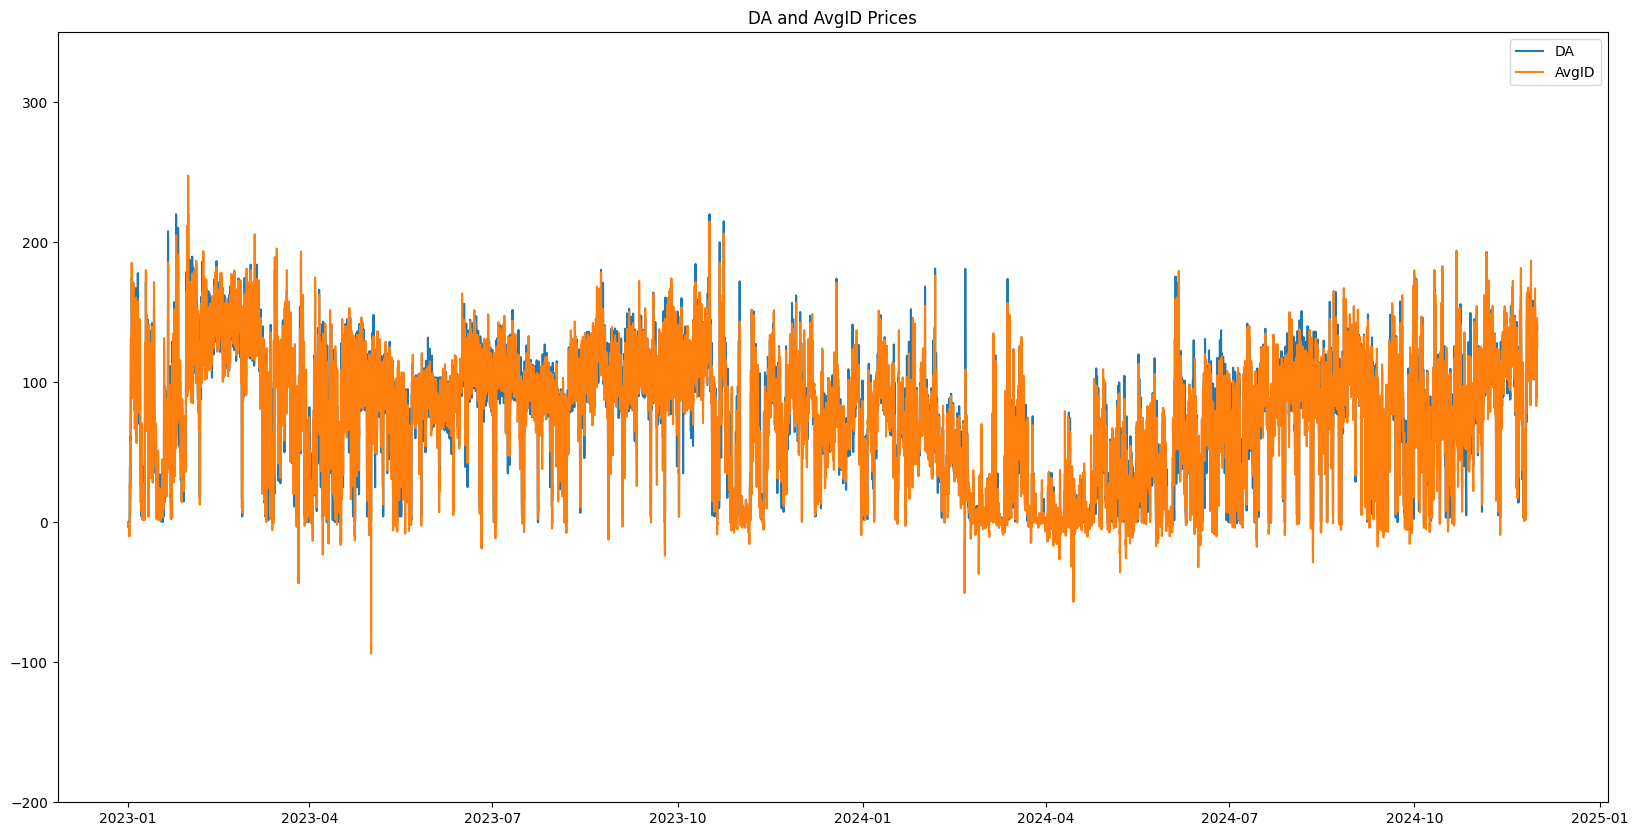

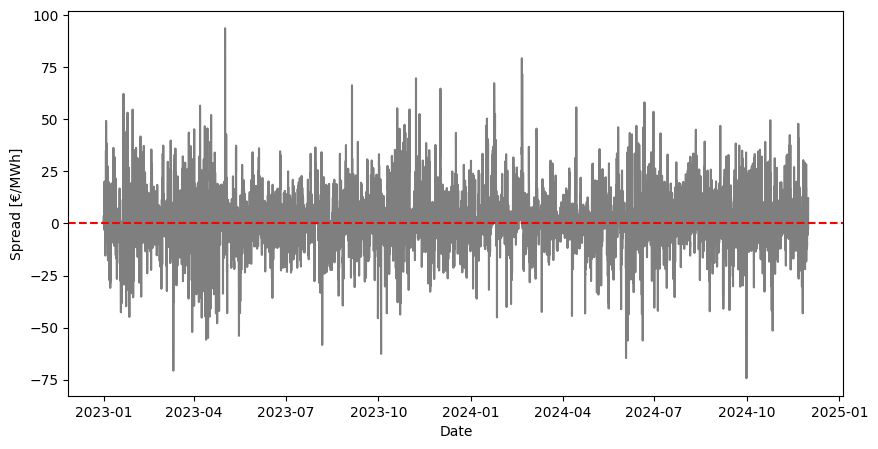

C:\Users\storr\AppData\Local\Temp\ipykernel_46396\2924474376.py:26: RuntimeWarning: invalid value encountered in maximum
  max_abs_spread  = np.maximum(np.abs(min_spread),np.abs(max_spread))


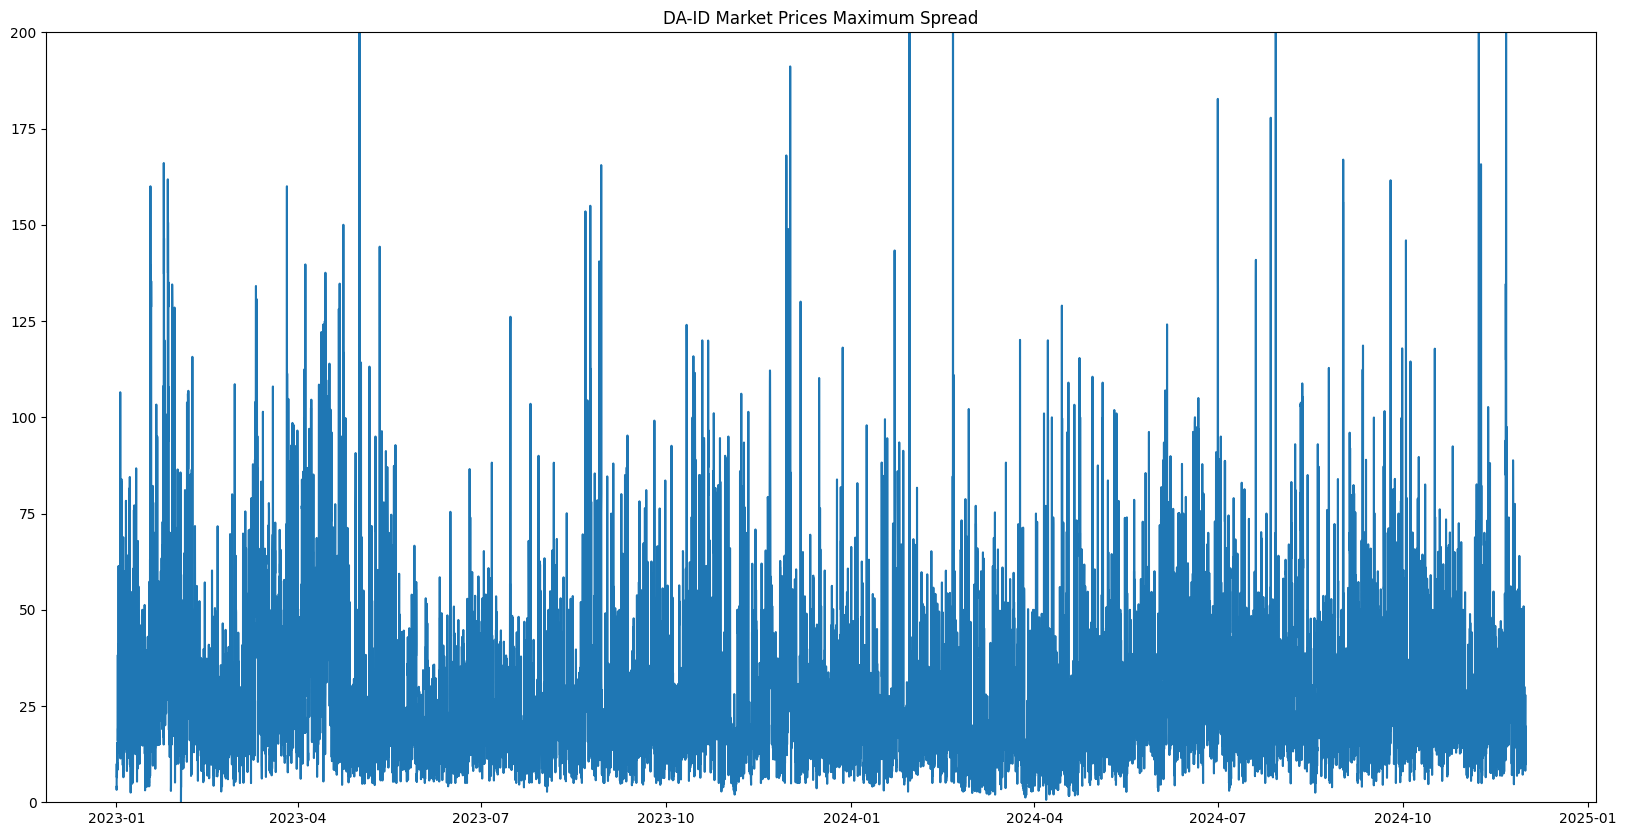

DA-AvgID Market Prices Spread Mean: 8.056215025598254
DA-ID Market Prices Maximum Spread Mean 28.712121085843627


In [19]:
# Plotting DA, MaxID, MinID, AvgID
# converting first 4 date columns to date object
fig  = plt.figure(figsize=(20,10))
plt.plot(pd.to_datetime(data_da.iloc[:,:4]),data_da.iloc[:,-1], label = 'DA')
plt.plot(pd.to_datetime(data_id.iloc[:,:4]),data_id.iloc[:,-1], label = 'AvgID')
#plt.plot(pd.to_datetime(data_id.iloc[:,:4]),data_id.iloc[:,-2], label = 'MinID')
#plt.plot(pd.to_datetime(data_id.iloc[:,:4]),data_id.iloc[:,-3], label = 'MaxID')

plt.title('DA and AvgID Prices')
plt.ylim([-200,350])
plt.legend()
plt.show()

# Plotting diff between DA and AvgID
fig  = plt.figure(figsize=(10,5))
plt.plot(pd.to_datetime(data_da.iloc[:,:4]),data_da.iloc[:,-1].values-data_id.iloc[:,-1].values,color='#7F7F7F')
plt.axhline(0,linestyle='--',color='r')
plt.xlabel('Date')
plt.ylabel('Spread [€/MWh]')
#plt.title('DA-AvgID Market Prices Spread')
plt.show()

# Plotting max absolute spead from DA and MinID-MaxID prices
min_spread  = data_da.iloc[:,-1].values-data_id.iloc[:,-2].values
max_spread  = data_id.iloc[:,-3].values - data_da.iloc[:,-1].values
max_abs_spread  = np.maximum(np.abs(min_spread),np.abs(max_spread))

fig  = plt.figure(figsize=(20,10))
plt.plot(pd.to_datetime(data_da.iloc[:,:4]),max_abs_spread)
plt.ylim([0,200])
plt.title('DA-ID Market Prices Maximum Spread')
plt.show()


print('DA-AvgID Market Prices Spread Mean:', np.nanmean(np.abs(np.array(data_da.iloc[:,-1].values-data_id.iloc[:,-1].values))))
print('DA-ID Market Prices Maximum Spread Mean', np.nanmean(max_abs_spread))

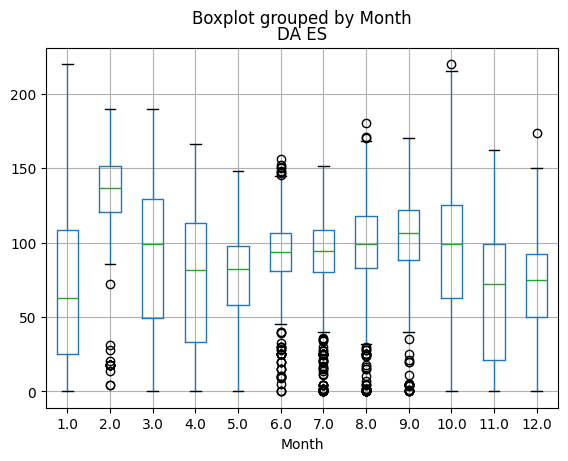

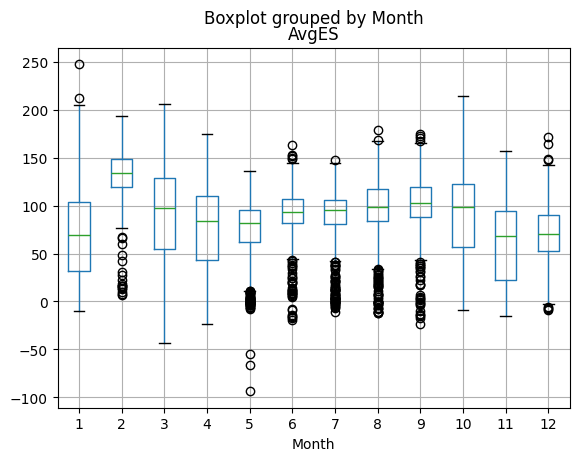

In [8]:
# monthly prices box plots

data_da.boxplot(column='DA ES', by='Month')
plt.show()

data_id['Month'] = data_id['Month'].apply(lambda x: int(x))

data_id.boxplot(column='AvgES', by='Month')
plt.show()


In [10]:
DA_diff_ID = data_da.iloc[:,-1].values-data_id.iloc[:,-1].values
positive_values_ratio = np.mean(DA_diff_ID>0)*100 # percentage of times when DA price is higher than ID price
print(positive_values_ratio)

54.36073059360731


C:\Users\storr\AppData\Local\Temp\ipykernel_46396\705314895.py:2: RuntimeWarning: invalid value encountered in greater
  positive_values_ratio = np.mean(DA_diff_ID>0)*100
